# Enoncé
## Application:
On considère le site: www.imdb.com

1- Analyse du Site Web :

On considère le site imdb et cette URL : https://www.imdb.com/title/tt0108778/episodes/ .inspectez la structure HTML pour comprendre comment les informations de la série ,ses épisodes et les différentes saisons sont présentées. Identifiez les balises HTML, les classes et les IDs pertinents qui contiennent les données que vous souhaitez extraire.

2-Extraction des Informations de Base :

2.1- les épisodes de la saison 1:
Utilisez Beautiful Soup pour envoyer une requête HTTP à la page https://www.imdb.com/title/tt0108778/episodes/ récupérez le contenu HTML. Récupérez la liste des episodes de la 1ere saison. Récupérer pour chaque épisode , son numéro, son nom, la date de sortie, la note et la description

2.2-Récupérer toutes les saisons
Etendre votre travail précédent pour extraire les les épisodes des 10 saisons de la série

In [1]:
SITE_URL = "https://www.imdb.com"

## Importations des livrairies nécessaires

In [2]:
import requests
import re
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support.expected_conditions import visibility_of_element_located

## Définition de fonction pour extraire de l'information sur une page

In [3]:
# Extract top actors in episod
def extract_episode_actors_info(url, episod, season):
    
    driver.get(url)
    content = driver.page_source
    soup = BeautifulSoup(content, 'html.parser')
    
    grid = soup.find_all('div',{'data-testid':'title-cast-item'})
    actors = []
    
    for tile in grid:
        actor = tile.find("a", {"data-testid": "title-cast-item__actor"}).text
        actors.append({"actor": actor, "episod": episod, "season": season})
    
    return actors

In [4]:
# Extract all informations in a card
def extract_session_info(url):
    
    driver.get(url)
    content = driver.page_source
    soup = BeautifulSoup(content, 'html.parser')
    
    articles = soup.find_all('article',{'class':'episode-item-wrapper'})
    episods_list = []
    actor_list = []
    
    for article in articles:
        title_season_episod = article.find("h4").text
        title_elements = title_season_episod.split("∙")
        title = title_elements[1]
        episod_infos = title_elements[0].strip().split(".")
        season, episod = episod_infos[0], episod_infos[1]
        desc = article.find("div", {"class": "ipc-html-content-inner-div"}).text
        episod_url_suffixe = article.find("a", {"class": "ipc-title-link-wrapper"}).attrs["href"]
        episod_url = SITE_URL +  episod_url_suffixe if episod_url_suffixe else None

        actors = extract_episode_actors_info(episod_url, episod, season)
        
        rate_group = article.find("span", {"class":"ratingGroup--imdb-rating"}).text.replace("\xa0", " ").split(" ")
        rating = rate_group[0].split("/")[0]
        vote_nb = rate_group[1].strip().replace("(", "") + " " + rate_group[2].strip().replace(")", "")
        date = article.find("span", {"class": "sc-ccd6e31b-10"}).text
        
        actor_list = actor_list + actors
        episods_list.append({"title": title, "description": desc, "season": season, "episod": episod, "rating": rating, "vote": vote_nb, "date": date})
    
    return episods_list, actor_list

In [ ]:
driver = webdriver.Chrome()    
episod_list, actor_list = [], []

for id_saison in range(1, 11):
    episods, actors = extract_session_info(f"https://www.imdb.com/title/tt0108778/episodes/?season={id_saison}")
    episod_list = episod_list + episods 
    actor_list = actor_list + actors

In [ ]:
df_actor = pd.DataFrame.from_dict(actor_list) 

In [ ]:
df_actor.head()

In [ ]:
df_actor.info()

In [ ]:
df_episod = pd.DataFrame.from_dict(episod_list)

In [ ]:
df_episod

### Sauvegarde de données traités pour la réutilisation, sans scraper une fois à nouveau

In [ ]:
df_actor.to_csv("data/actors.csv")
df_episod.to_csv("data/episods.csv")

### Lecture de données sauvegardées

In [99]:
df_play = pd.read_csv("data/actors.csv", index_col=[0])
df = pd.read_csv("data/episods.csv", index_col=[0])

### Préparation de données pour injection dans la BDD MySQL

In [100]:
def french_date_to_english(date_string):
    month_dict = {
        'janv.': 'Jan', 'févr.': 'Feb', 'mars': 'Mar', 'avr.': 'Apr',
        'mai': 'May', 'juin': 'Jun', 'juil.': 'Jul', 'août': 'Aug',
        'sept.': 'Sep', 'oct.': 'Oct', 'nov.': 'Nov', 'déc.': 'Dec'
    }
    for fr, en in month_dict.items():
        date_string = date_string.replace(fr, en)
    return date_string

In [101]:
df["date"] = df["date"].str.split(',').str[1].str.strip()
df["date"] = df["date"].apply(french_date_to_english)
df['date'] = pd.to_datetime(df['date'], format='%d %b %Y')
df["rating"] = df["rating"].str.replace(",",".").astype(float)
df["vote"] = df["vote"].apply(lambda x: int(float(x.replace('k', '').strip().replace(",", "."))*1000) if 'k' in x else x)
df.index.rename('id', inplace=True)

In [102]:
df_episods = pd.DataFrame(df["episod"].unique(), columns=['title'])
df_episods.index.rename('episod_id', inplace=True)

In [103]:
df_actor = pd.DataFrame(df_play["actor"].unique(), columns=['full_name'])
df_actor.index.rename('actor_id', inplace=True)

In [104]:
df_seasons = pd.DataFrame(df["season"].unique(), columns=['title'])
df_seasons.index.rename('season_id', inplace=True)

In [105]:
season_to_id_dict = dict(zip(df_seasons['title'].values, df_seasons.index.values))
df["season_id"] = df["season"].replace(season_to_id_dict)
df.drop('season', axis=1, inplace=True)

In [106]:
df_play["season_id"] = df_play["season"].replace(season_to_id_dict)
df_play.index.rename('play_id', inplace=True)
df_play.drop('season', axis=1, inplace=True)

actor_to_id_dict = dict(zip(df_actor['full_name'].values, df_actor.index.values))
df_play["actor_id"] = df_play["actor"].replace(actor_to_id_dict)
df_play.drop('actor', axis=1, inplace=True)

episod_to_id_dict = dict(zip(df_episods['title'].values, df_episods.index.values))
df["episod_id"] = df["episod"].replace(episod_to_id_dict)
df.drop('episod', axis=1, inplace=True)

df_play["episod_id"] = df_play["episod"].replace(episod_to_id_dict)
df_play.drop('episod', axis=1, inplace=True)

In [107]:
df_play.head()

,season_id,actor_id,episod_id
play_id,,,
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0


##  BDD

In [ ]:
#! pip  install  --upgrade  sqlalchemy
#! pip  install  --upgrade  sqlalchemy-utils

In [110]:
import pymysql
from sqlalchemy import create_engine,text
from sqlalchemy_utils import database_exists, create_database
db_user = 'postgres'
db_user = 'root'
db_pass = ''
db_ip = '127.0.0.1'
db_name = 'db_friends'
engine = create_engine('mysql+pymysql://{}:{}@{}/{}'.format(db_user,db_pass,db_ip,db_name))
if not database_exists(engine.url): create_database(engine.url)

### Création de BDD et ingestion de données dans les tables

In [111]:
pd.DataFrame.to_sql(df, name="friends",con=engine, if_exists='replace')
pd.DataFrame.to_sql(df_actor, name="actor",con=engine, if_exists='replace')
pd.DataFrame.to_sql(df_play, name="play",con=engine, if_exists='replace')
pd.DataFrame.to_sql(df_episods, name="episod",con=engine, if_exists='replace')
pd.DataFrame.to_sql(df_seasons, name="season",con=engine, if_exists='replace')

10

### Définition de clés primaires et clés étrangères

In [112]:
with engine.connect() as con:
    con.execute(text('USE db_friends;'))
    con.execute(text('ALTER TABLE friends ADD CONSTRAINT PK_friend PRIMARY KEY (id);'))
    con.execute(text('ALTER TABLE friends ADD FOREIGN KEY (season_id) REFERENCES season(season_id);'))
    con.execute(text('ALTER TABLE friends ADD FOREIGN KEY (episod_id) REFERENCES episod(episod_id);'))
    
    con.execute(text('ALTER TABLE actor ADD CONSTRAINT PK_actor PRIMARY KEY (actor_id);'))

    con.execute(text('ALTER TABLE play ADD CONSTRAINT PK_play PRIMARY KEY (play_id);'))
    con.execute(text('ALTER TABLE play ADD FOREIGN KEY (season_id) REFERENCES season(season_id);'))
    con.execute(text('ALTER TABLE play ADD FOREIGN KEY (actor_id) REFERENCES actor(actor_id);'))
    con.execute(text('ALTER TABLE play ADD FOREIGN KEY (episod_id) REFERENCES episod(episod_id);'))
    
    con.execute(text('ALTER TABLE season ADD CONSTRAINT PK_season PRIMARY KEY (season_id);'))
    con.execute(text('ALTER TABLE episod ADD CONSTRAINT PK_episod PRIMARY KEY (episod_id);'))

## Analyse

### SQL

In [113]:
# Set function as our sql_to_pandas
def sql_to_df(sql_query):

    # Use pandas to pass sql query using connection form Mysql/SQLite3/postgresql
    df = pd.read_sql_query(text(sql_query), engine.connect())

    # Show the resulting DataFrame
    return df

In [114]:
sql_to_df("SELECT * FROM actor limit 5;")

,actor_id,full_name
0,0,Jennifer Aniston
1,1,Courteney Cox
2,2,Lisa Kudrow
3,3,Matt LeBlanc
4,4,Matthew Perry


In [115]:
sql_to_df("SELECT * FROM play limit 5;")

,play_id,season_id,actor_id,episod_id
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,0,3,0
4,4,0,4,0


In [116]:
sql_to_df("SELECT * FROM episod limit 5;")

,episod_id,title
0,0,E1
1,1,E2
2,2,E3
3,3,E4
4,4,E5


In [117]:
sql_to_df("SELECT * FROM season limit 5;")

,season_id,title
0,0,S1
1,1,S2
2,2,S3
3,3,S4
4,4,S5


In [118]:
sql_to_df("SELECT * FROM friends limit 5;")

,id,title,description,rating,vote,date,season_id,episod_id
0,0,The One Where Monica Gets a Roommate,"Monica and the gang introduce Rachel to the ""r...",8.1,10000,1996-04-16,0,0
1,1,The One with the Sonogram at the End,Ross finds out his ex-wife is pregnant. Rachel...,7.9,8000,1994-09-29,0,1
2,2,The One with the Thumb,Monica becomes irritated when everyone likes h...,8.0,7500,1994-10-06,0,2
3,3,The One with George Stephanopoulos,Joey and Chandler take Ross to a hockey game t...,7.9,7300,1994-10-13,0,3
4,4,The One with the East German Laundry Detergent,"Eager to spend time with Rachel, Ross pretends...",8.3,7300,1994-10-20,0,4


###  Analyse sur votes totaux par saison

In [119]:
df_episod_sql_output = sql_to_df("""
SELECT   s.title as season, SUM(vote) as total_vote
FROM friends f
INNER JOIN season s ON s.season_id = f.season_id  
GROUP BY season
;""")

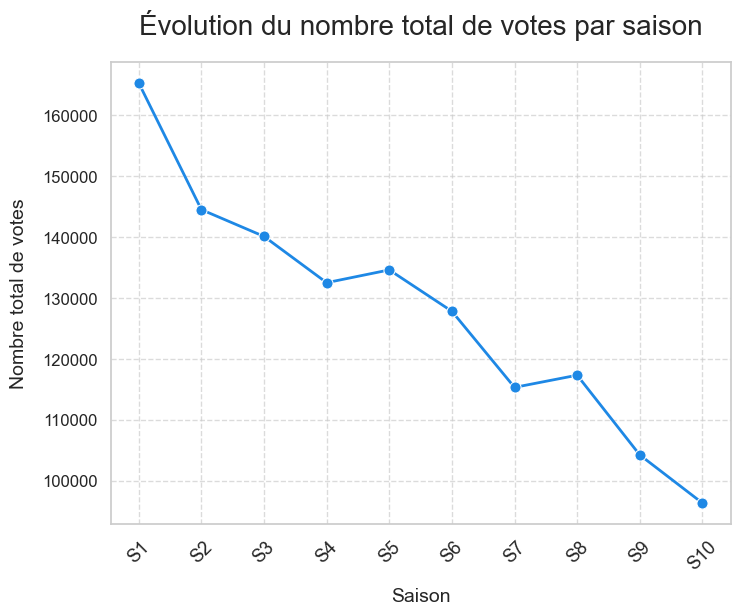

In [120]:
# Tendance des votes totaux par saison
plt.figure(figsize=(8, 6))
sns.lineplot(x="season", 
             y="total_vote", 
             data=df_episod_sql_output,
             marker='o',
             linewidth=2,
             color='#1e88e5',
             markersize=8 )

plt.title("Évolution du nombre total de votes par saison", fontsize=20, pad=20)
plt.xlabel("Saison", fontsize=14, labelpad=10)
plt.ylabel("Nombre total de votes", fontsize=14, labelpad=10)

# Personnaliser les ticks
plt.xticks(rotation=45)
plt.yticks(fontsize=12)

# Ajouter une grille légère
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Le graphique montre une décroissance constante du nombre total de votes à mesure que les saisons avancent.

###  Analyse sur note moyenne par saison

In [121]:
df_episod_avg_rating_sql_output = sql_to_df("""
SELECT s.title as season, AVG(rating) as avg_rating
FROM friends f
INNER JOIN season s ON s.season_id = f.season_id  
GROUP BY season
;""")

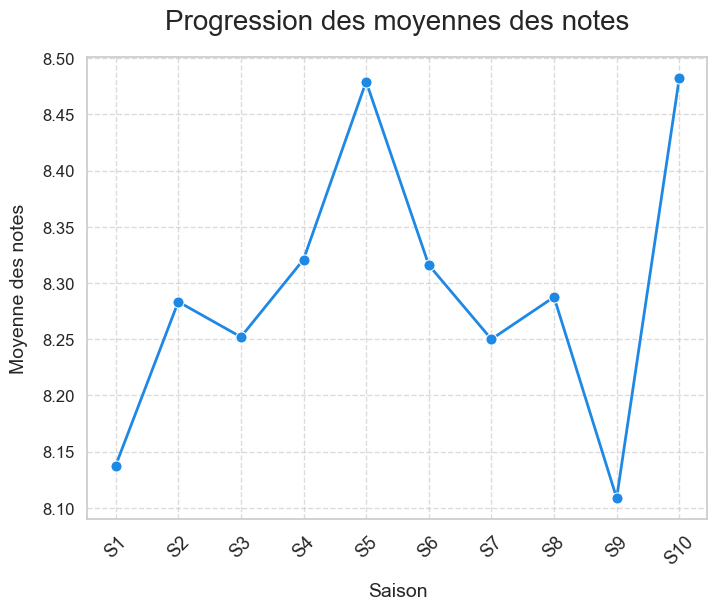

In [122]:
# Progression des moyennes des notes
plt.figure(figsize=(8, 6))
sns.lineplot(x="season", 
             y="avg_rating", 
             data=df_episod_avg_rating_sql_output,
             marker='o',
             linewidth=2,
             color='#1e88e5',
             markersize=8 )

plt.title("Progression des moyennes des notes", fontsize=20, pad=20)
plt.xlabel("Saison", fontsize=14, labelpad=10)
plt.ylabel("Moyenne des notes", fontsize=14, labelpad=10)

# Personnaliser les ticks
plt.xticks(rotation=45)
plt.yticks(fontsize=12)

# Ajouter une grille légère
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

L'analyse des moyennes des notes par saison ne révèle pas de tendance significative.

### La meilleure épisode

In [123]:
df_best_rating_sql_output = sql_to_df("""
SELECT f.title as title, f.rating as rating, CONCAT(s.title, e.title) as episod
FROM friends f
INNER JOIN season s ON s.season_id = f.season_id  
INNER JOIN episod e ON e.episod_id = f.episod_id 
ORDER BY f.rating DESC
LIMIT 10
;""")

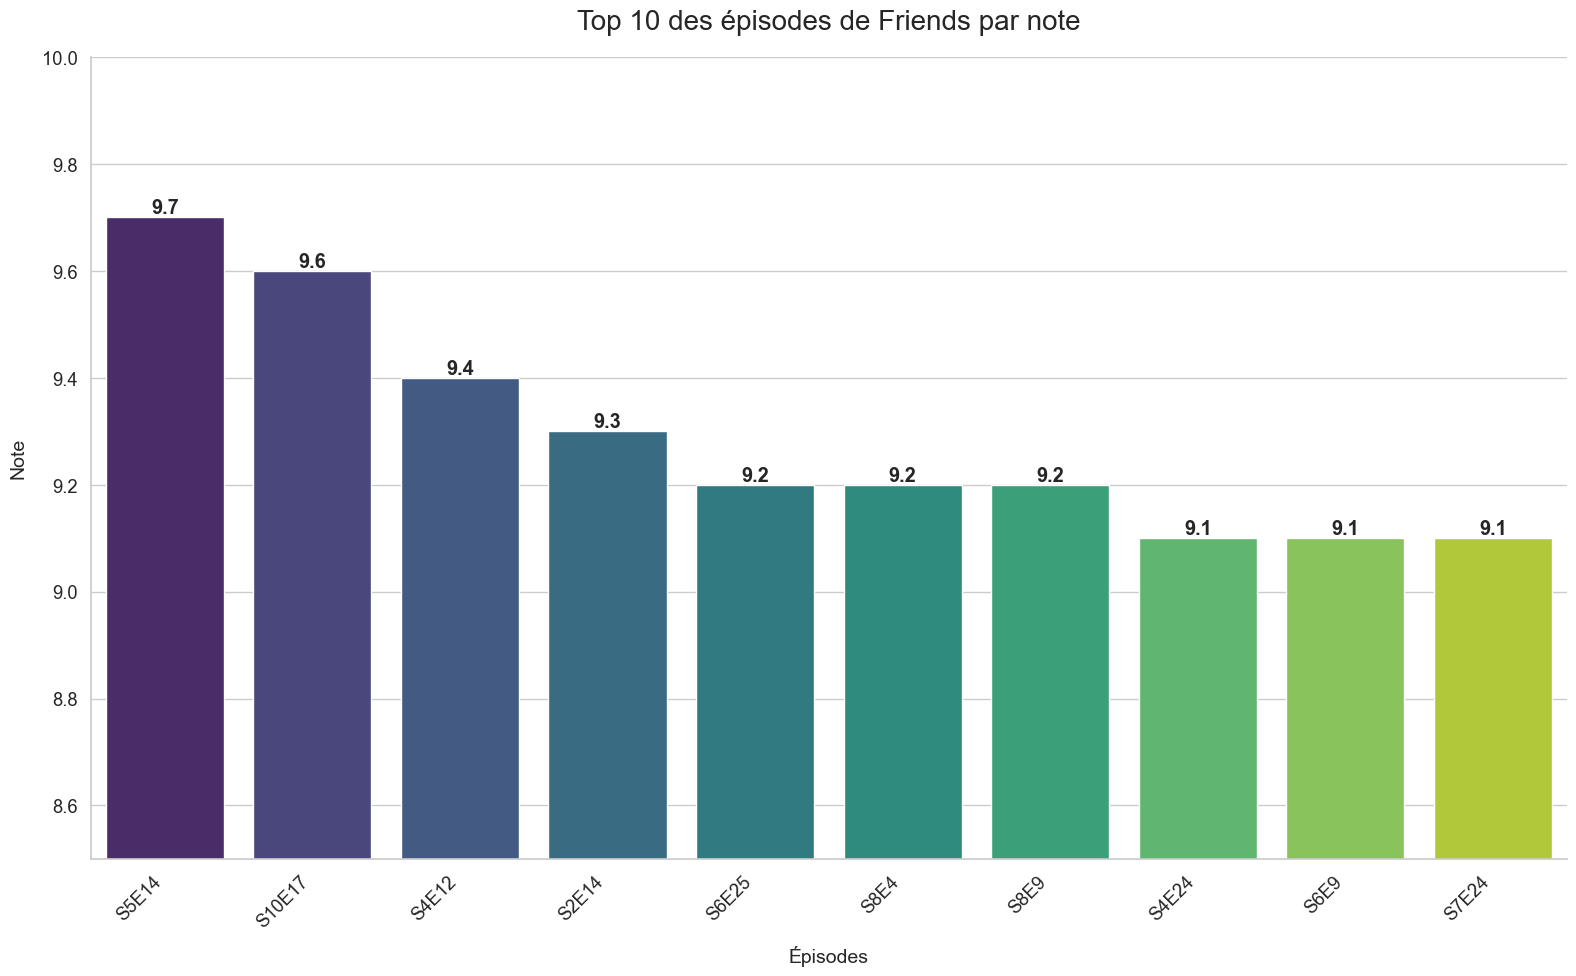

In [124]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Créer la figure et les axes
plt.figure(figsize=(16, 10))

# Créer le barplot
ax = sns.barplot(
    x='episod', 
    y='rating', 
    data=df_best_rating_sql_output,
    palette='viridis'
)

plt.title('Top 10 des épisodes de Friends par note', fontsize=20, pad=20)
plt.xlabel('Épisodes', fontsize=14, labelpad=10)
plt.ylabel('Note', fontsize=14, labelpad=10)

# Rotation des étiquettes de l'axe x pour une meilleure lisibilité
plt.xticks(rotation=45, ha='right')

# Ajouter les valeurs sur chaque barre
for i, v in enumerate(df_best_rating_sql_output['rating']):
    ax.text(i, v, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

# Ajuster l'axe y
plt.ylim(8.5, 10)

# Supprimer les bordures supérieure et droite
sns.despine()

# Ajuster la mise en page et afficher
plt.tight_layout()
plt.show()

La saison S5E14 a une plus haute note.

### Analyse sur acteurs

In [174]:
df_actor_play_in_episod_sql_output = sql_to_df("""
SELECT   
    a.full_name as actor, COUNT(*) as nb_episods
FROM play p
INNER JOIN actor a ON a.actor_id = p.actor_id
INNER JOIN episod e ON e.episod_id = p.episod_id 
INNER JOIN season s ON s.season_id = p.season_id
GROUP BY actor
ORDER BY nb_episods DESC
LIMIT 20
;""")

In [175]:
df_actor_play_in_episod_sql_output[5:10]

,actor,nb_episods
5,David Schwimmer,234
6,James Michael Tyler,161
7,Elliott Gould,22
8,Maggie Wheeler,20
9,Christina Pickles,20


<Axes: xlabel='nb_episods', ylabel='actor'>

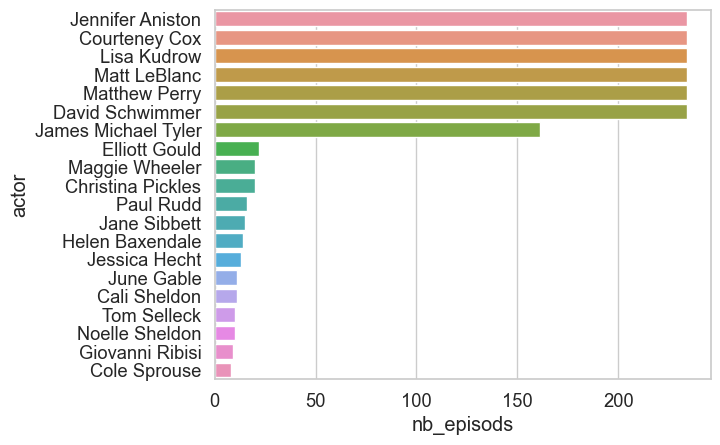

In [176]:
sns.barplot(y="actor", x="nb_episods", data=df_actor_play_in_episod_sql_output)